In [11]:
# install tessaract
!pip install pytesseract

In [15]:
!pip install imutils

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25857 sha256=6845dffdec842e7fe5d39c78d22ac92ec161a216c8a6a666952a06c560f30abb
  Stored in directory: c:\users\tarek\appdata\local\pip\cache\wheels\5b\76\96\ad0c321506837bef578cf3008df3916c23018435a355d9f6b1
Successfully built imutils


In [25]:
import warnings

# Suppress all deprecation warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module='cryptography')


In [69]:
import cv2
import imutils
import pytesseract
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import clear_border

In [71]:
# setting the minimum and maximum aspect ratio to detect and filter rectangular license plates
# these aspect ratio corresponds to the typical rectangular dimensions of a license plate
min_ar = 4
max_ar = 5

In [73]:
# defining path for vechiles 
bmw_path = "Images/bmw.jpg"
mbenz_path = "Images/mercedes.jpg"
ferrari_path = "Images/ferrari.jpg"

Image shape: (848, 1280, 3)


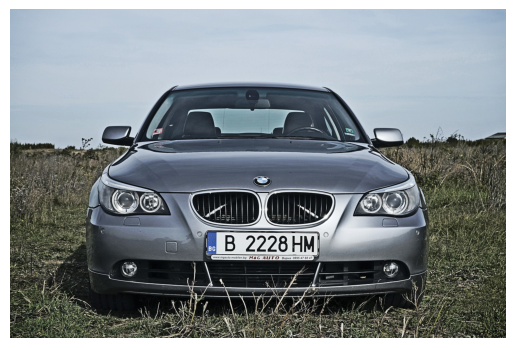

In [75]:
bmw_img = cv2.imread(bmw_path)
print(f"Image shape: {bmw_img.shape}")
plt.imshow(bmw_img[:,:,::-1])
plt.axis("off")
plt.show()

Gray image shape: (848, 1280)
Blackhat shape: (848, 1280)


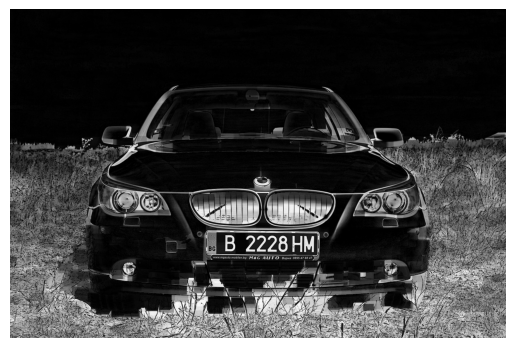

In [77]:
# FUNCTION TO LOCATE POTENTIAL LICENSE PLATE CANDIDATE
# To get structural elements and morphology, we are required to convert the RGB image into grayscale
# we will perform blackhat morphilogical operation that will allow us to reveal dark regions on dark background
gray_bmw = cv2.cvtColor(bmw_img, cv2.COLOR_BGR2GRAY)
print(f"Gray image shape: {gray_bmw.shape}")
rect_kern = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 15))
blackhat = cv2.morphologyEx(gray_bmw, cv2.MORPH_BLACKHAT, rect_kern)

# now we will plot the image 
print(f"Blackhat shape: {blackhat.shape}")
plt.imshow(blackhat, cmap='gray')
plt.axis("off")
plt.show()

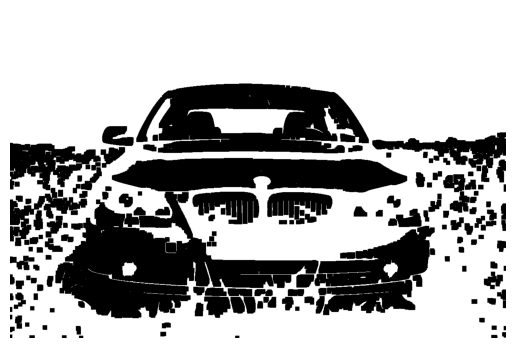

In [79]:
# now we will find the regions that are light and may contain license plate characters
# creates a structuring element for a morphological operation.
square_kern = cv2.getStructuringElement(cv2.MORPH_RECT, (11,11))
light = cv2.morphologyEx(gray_bmw, cv2.MORPH_CLOSE, square_kern)
light = cv2.threshold(light, 0, 255,
                     cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
plt.imshow(light, cmap='gray')
plt.axis("off")
plt.show()

Minimum and Maximum values of grad x: (0.0, 255.0)


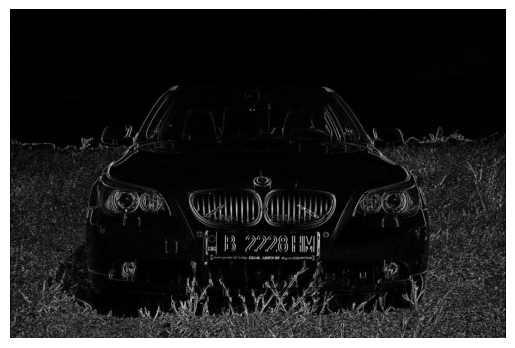

In [81]:
# compute the Scharr gradient representation of the balckhat 
# image in the x-dieredction and then scale the results back to range [0, 255]
grad_x = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=1)
grad_x = np.absolute(grad_x)
(min_val, max_val) = (np.min(grad_x), np.max(grad_x))
print(f"Minimum and Maximum values of grad x: {(min_val, max_val)}")
grad_x = 255 * ((grad_x - min_val) / (max_val - min_val))
grad_x = grad_x.astype("uint8")
plt.imshow(grad_x, cmap='gray')
plt.axis("off")
plt.show()

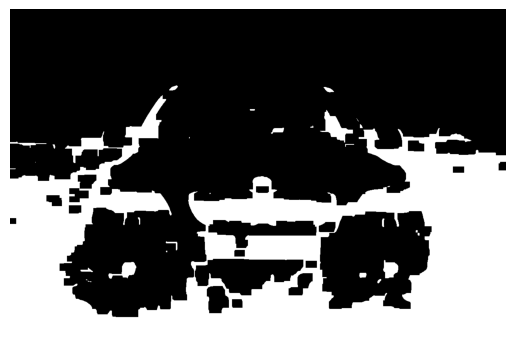

In [83]:
# the license plate number characters are noticeably different from the rest of the image
# we can now smooth to group the regions that may contain boundaries to characters
# bluring the gradient representation, applying a closing operation, 
# and threshold the image using Otsu's method

grad_x_blur = cv2.GaussianBlur(grad_x, (11,11), 0)
grad_x_morph = cv2.morphologyEx(grad_x_blur, cv2.MORPH_CLOSE, rect_kern)
thresh = cv2.threshold(grad_x_morph, 0, 255,
                      cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

plt.imshow(thresh, cmap='gray')
plt.axis("off")
plt.show()

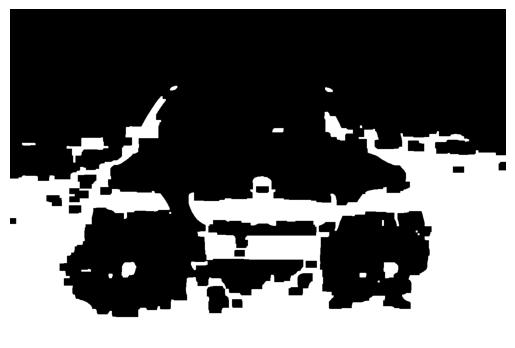

In [85]:
# these resutls looks cluttered, the license platre region is somewhat defined
# but there are many other white region as well 
# now, we will eliminat some of those noise 
# perform a series of erosions and dialations to clean up the thresholded image
thresh_clean = cv2.erode(thresh, None, iterations=2)
thresh_clean = cv2.dilate(thresh_clean, None, iterations=2)

plt.imshow(thresh_clean, cmap='gray')
plt.axis("off")
plt.show()

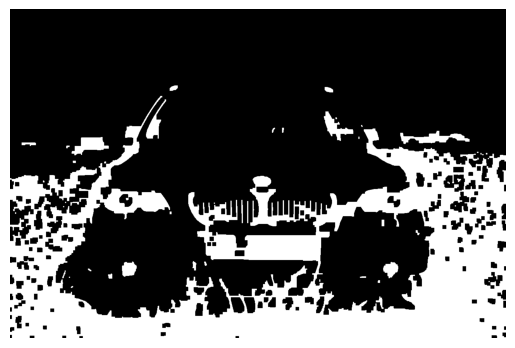

In [87]:
# now, we will put our light nregions image to use 
# take the bitwise AND between the threshold results and the 
# light region of the image
thresh_f = cv2.bitwise_and(thresh_clean, thresh_clean, mask=light)
thresh_f = cv2.dilate(thresh_f, None, iterations=2)
thresh_f = cv2.erode(thresh_f, None, iterations=1)

plt.imshow(thresh_f, cmap='gray')
plt.axis('off')
plt.show()

In [89]:
# find contours in the thresholded image and sort them by their size
# in descending order, keeping only the largest ones 
keep = 5
cnts = cv2.findContours(thresh_f.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:keep]
# enf of the function 

Ar value: 2.051282051282051


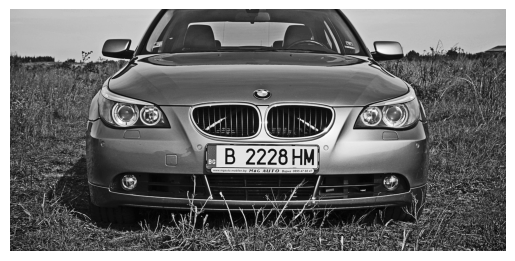

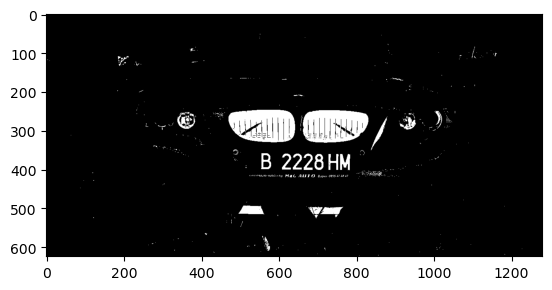

In [91]:
# WE ANOTHER FUCNTION TO LOCATE THE LICENSE PLATE 
# our goal is to find the most likely countour containing a license plate 
# from out set of candidates 
"""
candidates: the license plate contour candidates returned by the previous
method (cnts) 
clearBoarder: A boolean indicating whether our pipeline should eliminate
any contours that touch the edge of the image
"""

# initialize the license plate contour and ROI
lp_cnt = None
roi = None 
min_ar= 1
max_ar = 4
candidates = cnts
clearBorder = True

# loop over the license plat candidate contours 
for c in candidates:
    # compute the bounding box of the contour and then use bounding box
    # to derive the aspect ratio
    (x, y, w, h) = cv2.boundingRect(c)
    ar = w / float(h)
    print(f"Ar value: {ar}")
    # check to see if the aspect ratio is a rectangular
    if ar >= min_ar and ar<=max_ar:
        # store the license plate contour and extract the license plate 
        # from the grayscale image and then threshold it 
        lp_cnt = c
        license_plate = gray_bmw[y:y + h, x:x +w]
        roi = cv2.threshold(license_plate, 0, 255,
                           cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        # check to see if we should clear any foreground 
        # pixels touching the border of the image 
        # which typically, not but always indicates noise 
        if clearBorder:
            roi = clear_border(roi)
        # display any debugging information mand then break 
        # from the loop early since we have found the license plate region 
        plt.imshow(license_plate, cmap='gray')
        plt.axis('off')
        plt.show()
        plt.imshow(roi, cmap='gray')
        plt.show()
        break
    

##### OCR Part

In [93]:
def build_tesseract_options(psm=7):
		# tell Tesseract to only OCR alphanumeric characters
		alphanumeric = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
		options = "-c tessedit_char_whitelist={}".format(alphanumeric)
		# set the PSM mode
		options += " --psm {}".format(psm)
		# return the built options string
		return options

In [31]:
roi

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [242]:
C:\Users\Tarek\AppData\Local\Programs\Tesseract-OCR

(48, 125, 3)

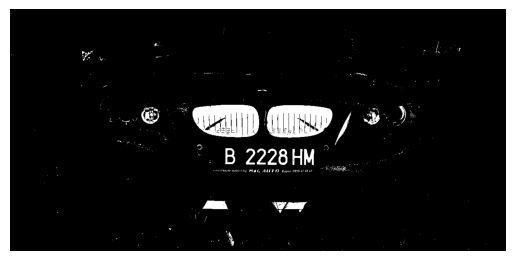

Text: B2228HM



In [107]:
# initialize the license plate text
# roi, lp_cnt, candidates
# psm is factor to determine the perfect ocr
psm = 3
lpText = None
if roi is not None:
    # OCR the license plate
    options = build_tesseract_options(psm=psm)
    lpText = pytesseract.image_to_string(roi, config=options)
    plt.imshow(roi, cmap='gray')
    plt.axis('off')
    plt.show()
print(f"Text: {lpText}")

In [109]:
lpText

'B2228HM\n'

Image shape: (48, 125, 3)


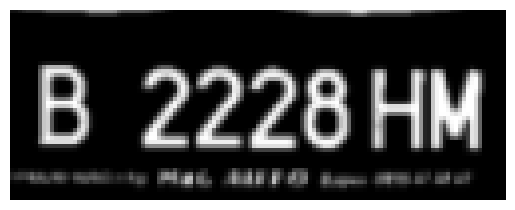

In [53]:
import cv2
import matplotlib.pyplot as plt

# Load image
demo = cv2.imread("Images/d.png")

# Check if the image is None
if demo is None:
    print("Error: Image not found or unable to load!")
else:
    print(f"Image shape: {demo.shape}")  # Should print (H, W, C)
    plt.imshow(demo[:,:,::-1])  # Convert BGR to RGB for proper visualization
    plt.axis('off')
    plt.show()


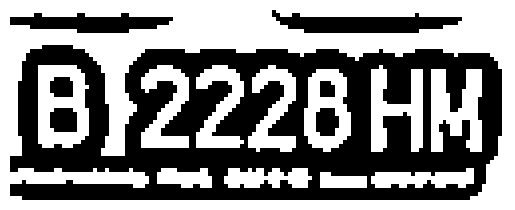

In [55]:
# Convert to grayscale
demo = cv2.cvtColor(demo, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise
demo = cv2.GaussianBlur(demo, (3,3), 0)

# Apply adaptive thresholding for better contrast
demo = cv2.adaptiveThreshold(demo, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

# Show processed image
plt.imshow(demo, cmap='gray')
plt.axis('off')
plt.show()


In [59]:
# Try different PSM values
for psm in [6, 7, 8, 11]:  # Experiment with these modes
    print(f"Trying PSM {psm}...")
    config = f'--psm {psm} --oem 3'  # OEM 3 uses deep learning-based OCR

    lpText = pytesseract.image_to_string(demo, config=config)
    print(f"Extracted Text (PSM {psm}): {lpText.strip()}")

    if lpText.strip():  # If text is detected, break the loop
        break

Trying PSM 6...
Extracted Text (PSM 6): 
Trying PSM 7...
Extracted Text (PSM 7): 
Trying PSM 8...
Extracted Text (PSM 8): By222604


In [61]:
config = '--psm 8 --oem 3 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
lpText = pytesseract.image_to_string(demo, config=config)

print(f"Refined Extracted Text: {lpText.strip()}")


Refined Extracted Text: BY222604


In [63]:
lpText = lpText.strip().replace("\n", "").replace(" ", "")
print(f"Cleaned Text: {lpText}")


Cleaned Text: BY222604


In [65]:
config = "--oem 3 --psm 8 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
lpText = pytesseract.image_to_string(demo, config=config)
print(f"Refined Extracted Text: {lpText.strip()}")


Refined Extracted Text: BY222604


In [67]:
lpText

'BY222604\n'

In [33]:
import pytesseract

# Manually set the path where Tesseract is installed
pytesseract.pytesseract.tesseract_cmd = r"C:\Users\Tarek\AppData\Local\Programs\Tesseract-OCR\tesseract.exe"

# Test if it works
print(pytesseract.get_tesseract_version())


5.5.0.20241111


#### Bengali Number Extraction

In [2]:
import cv2
import imutils
import pytesseract
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import clear_border

C:\Users\Tarek\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\Tarek\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Users\Tarek\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [34]:
# define the image path 
root_fold = "Images/"

# function to generate path of certain group images 
def generate_paths(root_fold, prefix, num_images):
    """
    This function take the root folder where the images are kept, prefix and num of images,
    which aims to generate the path of those images and dump into a dictionary for easier usage
    """
    img_group = {}
    for k in range(1, num_images+1):
        if k not in img_group:
            # all of our images are in jpg format 
            img_group[k] = root_fold + prefix + str(k) + ".jpg"
    return img_group

# generating image paths based on our directory
img_group_1 = generate_paths(root_fold=root_fold, prefix= "bn_1", num_images=4)
img_group_2 = generate_paths(root_fold=root_fold, prefix="bn_2", num_images=5)
img_group_3 = generate_paths(root_fold=root_fold, prefix="bn_3", num_images=2)
img_group_4 = generate_paths(root_fold=root_fold, prefix="bn_4", num_images=5)
img_group_5 = generate_paths(root_fold=root_fold, prefix="bn_5", num_images=7)
img_group_6 = generate_paths(root_fold=root_fold, prefix="bn_6", num_images=4)

Shape of the image: (59, 59, 3)


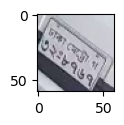

In [70]:
# defining an image from the image group 1
g1_img_1 = cv2.imread(img_group_6[2])
print(f"Shape of the image: {g1_img_1.shape}")
plt.figure(figsize=(2, 1))
plt.imshow(g1_img_1[:, :, ::-1])
plt.show()

Shape of the image: (60, 59, 3)


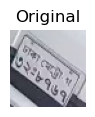

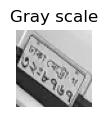

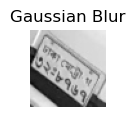

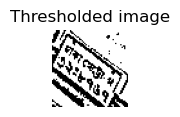

Text using the original image: 
Text using the gray image: 
Text using the threshold image: 


In [146]:
# defining the plot size
plt.rcParams['figure.figsize'] = (2, 1)

# defining image 
g1_img_1 = cv2.imread(img_group_6[1])
# g1_img_1 = cv2.imread("Images/lpn_1.png")

# original image
print(f"Shape of the image: {g1_img_1.shape}")
plt.title("Original")
plt.axis('off')
plt.imshow(g1_img_1[:, :, ::-1])
plt.show()

# convert the gray image 
gray_img = cv2.cvtColor(g1_img_1, cv2.COLOR_BGR2GRAY)
plt.title("Gray scale")
plt.axis('off')
plt.imshow(gray_img, cmap='gray')
plt.show()

# Apply Gaussian blur to reduce noise
gray_img = cv2.GaussianBlur(gray_img, (3,3), 0.5)
# plt.figure()
plt.title("Gaussian Blur")
plt.axis('off')
plt.imshow(gray_img, cmap='gray')
plt.show()

# Apply adaptive thresholding for better contrast
th_img = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
# plt.figure(figsize=(2, 1))
plt.title("Thresholded image")
plt.axis('off')
plt.imshow(th_img, cmap='gray')
plt.show()

# get the text 
org_text = pytesseract.image_to_string(g1_img_1, lang="ben")
print(f"Text using the original image: {org_text}")
g_text = pytesseract.image_to_string(gray_img, lang="ben")
print(f"Text using the gray image: {g_text}")
t_text = pytesseract.image_to_string(th_img, lang="ben")
print(f"Text using the threshold image: {t_text}")

Shape of the image: (262, 436, 3)


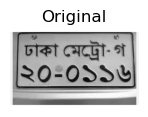

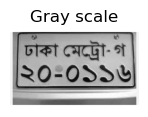

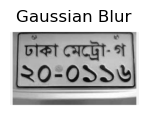

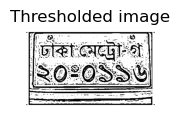

Text using the original image: ঢাকা মেক্রো-গ
২২০-০-১-১৬,

Text using the gray image: ঢাকা মেক্রো-গ
»২০-০৯১৯১

Text using the threshold image: 


In [148]:
# defining the plot size
plt.rcParams['figure.figsize'] = (2, 1)

# defining image 
# g1_img_1 = cv2.imread(img_group_6[1])
g1_img_1 = cv2.imread("Images/lpn_1.png")

# original image
print(f"Shape of the image: {g1_img_1.shape}")
plt.title("Original")
plt.axis('off')
plt.imshow(g1_img_1[:, :, ::-1])
plt.show()

# convert the gray image 
gray_img = cv2.cvtColor(g1_img_1, cv2.COLOR_BGR2GRAY)
plt.title("Gray scale")
plt.axis('off')
plt.imshow(gray_img, cmap='gray')
plt.show()

# Apply Gaussian blur to reduce noise
gray_img = cv2.GaussianBlur(gray_img, (3,3), 0.5)
# plt.figure()
plt.title("Gaussian Blur")
plt.axis('off')
plt.imshow(gray_img, cmap='gray')
plt.show()

# Apply adaptive thresholding for better contrast
th_img = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
# plt.figure(figsize=(2, 1))
plt.title("Thresholded image")
plt.axis('off')
plt.imshow(th_img, cmap='gray')
plt.show()

# get the text 
org_text = pytesseract.image_to_string(g1_img_1, lang="ben")
print(f"Text using the original image: {org_text}")
g_text = pytesseract.image_to_string(gray_img, lang="ben")
print(f"Text using the gray image: {g_text}")
t_text = pytesseract.image_to_string(th_img, lang="ben")
print(f"Text using the threshold image: {t_text}")

Shape of the image: (284, 551, 3)


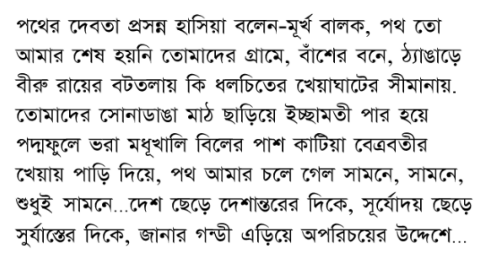

In [114]:
# defining the figsize
plt.rcParams['figure.figsize'] = (6, 4)

# trying on a random image that has bengali text 
bng_text_img = cv2.imread("Images/bengali_demo.png")
print(f"Shape of the image: {bng_text_img.shape}")
plt.imshow(bng_text_img[:,:, ::-1])
plt.axis("off")
plt.show()

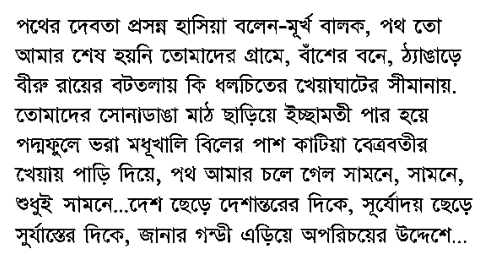

In [120]:
# convert bgr to rgb image 
gray_bng_img = cv2.cvtColor(bng_text_img, cv2.COLOR_BGR2GRAY)
t_bng_img = cv2.adaptiveThreshold(gray_bng_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
plt.imshow(t_bng_img, cmap='gray')
plt.axis("off")
plt.show()

In [122]:
t_text = pytesseract.image_to_string(t_bng_img, lang="ben")
print(f"Text using the threshold image: {t_text}")

Text using the threshold image: পথের দেবতা প্রসন্ন হাসিয়া বলেন-মূর্খ বালক, পথ তো

গ্রামে, বাশের বনে, ঠ্যাঙীড়ে

তোমাদের সোনাভাগা মাঠ ছা

পদ্মফুলে ভরা মধূখালি বিলের পাশ কাটিয়া বেত্রবতীর

খেয়ায় পাড়ি দিয়ে, পথ আম

র চলে গেল সামনে, সামনে,

শুধুই সামনে...দেশ ছেড়ে দেশান্তরের দিকে, সূর্যোদয় ছেড়ে

সূর্যাস্তের দিকে, জানার গন্ডী

